In [1]:
# edgevit.py

from collections import OrderedDict
import torch
import torch.nn as nn
from functools import partial
import torch.nn.functional as F
import math
from timm.models.vision_transformer import _cfg
from timm.models import register_model
from timm.models.layers import trunc_normal_, DropPath, to_2tuple


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class CMlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Conv2d(in_features, hidden_features, 1)
        self.act = act_layer()
        self.fc2 = nn.Conv2d(hidden_features, out_features, 1)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


import torch
import torch.nn as nn

class SEBlock(nn.Module):
    def __init__(self, dim, reduction=4):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim // reduction)  
        self.fc2 = nn.Linear(dim // reduction, dim)  
        self.act = nn.ReLU() 
        self.sigmoid = nn.Sigmoid() 

    def forward(self, x):
        """
        Input: x of shape [B, C, H, W]  (Batch, Channels, Height, Width)
        Output: x of shape [B, C, H, W] (Reweighted Feature Map)
        """
        B, C, H, W = x.shape

        # Squeeze - Global Average Pooling (GAP)
        w = x.mean(dim=[2, 3])  # Shape: [B, C]

        # Excite - Learn importance of channels
        w = self.fc1(w) 
        w = self.act(w)  
        w = self.fc2(w)  
        w = self.sigmoid(w) 

        #Multiply attention weights with original feature map
        w = w.unsqueeze(-1).unsqueeze(-1) 
        return x * w  


class GlobalSparseAttn(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        # self.upsample = nn.Upsample(scale_factor=sr_ratio, mode='nearest')
        self.sr = sr_ratio
        if self.sr > 1:
            self.sampler = nn.AvgPool2d(1, sr_ratio)
            kernel_size = sr_ratio
            self.LocalProp = nn.ConvTranspose2d(dim, dim, kernel_size, stride=sr_ratio, groups=dim)
            self.norm = nn.LayerNorm(dim)
        else:
            self.sampler = nn.Identity()
            self.upsample = nn.Identity()
            self.norm = nn.Identity()

    def forward(self, x, H: int, W: int):
        B, N, C = x.shape
        if self.sr > 1.:
            x = x.transpose(1, 2).reshape(B, C, H, W)
            x = self.sampler(x)
            x = x.flatten(2).transpose(1, 2)

        qkv = self.qkv(x).reshape(B, -1, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, -1, C)

        if self.sr > 1:
            x = x.permute(0, 2, 1).reshape(B, C, int(H / self.sr), int(W / self.sr))
            x = self.LocalProp(x)
            x = x.reshape(B, C, -1).permute(0, 2, 1)
            x = self.norm(x)

        x = self.proj(x)
        x = self.proj_drop(x)
        return x


# class LocalAgg(nn.Module):
#     def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
#                  drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
#         super().__init__()
#         self.pos_embed = nn.Conv2d(dim, dim, 3, padding=1, groups=dim)
#         self.norm1 = nn.BatchNorm2d(dim)
#         self.conv1 = nn.Conv2d(dim, dim, 1)
#         self.conv2 = nn.Conv2d(dim, dim, 1)
#         self.attn = nn.Conv2d(dim, dim, 5, padding=2, groups=dim)
#         self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
#         self.norm2 = nn.BatchNorm2d(dim)
#         mlp_hidden_dim = int(dim * mlp_ratio)
#         self.mlp = CMlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
#
#     def forward(self, x):
#         x = x + self.pos_embed(x)
#         x = x + self.drop_path(self.conv2(self.attn(self.conv1(self.norm1(x)))))
#         x = x + self.drop_path(self.mlp(self.norm2(x)))
#         return x

class LocalAgg(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.pos_embed = nn.Conv2d(dim, dim, 3, padding=1, groups=dim)  # Positional encoding
        self.attn = nn.Conv2d(dim, dim, 5, padding=2, groups=dim)  # Local attention
        self.norm1 = nn.BatchNorm2d(dim)
        self.norm2 = nn.BatchNorm2d(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = CMlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.se = SEBlock(dim) 

    def forward(self, x):
        identity = x

       
        x = x + self.pos_embed(x)
        x = x + self.attn(self.norm1(x))

     
        x = self.se(x)

       
        x = x + self.mlp(self.norm2(x))
        return x + identity  # Residual connection



class SelfAttn(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1.):
        super().__init__()
        self.pos_embed = nn.Conv2d(dim, dim, 3, padding=1, groups=dim)
        self.norm1 = norm_layer(dim)
        self.attn = GlobalSparseAttn(
            dim,
            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        # global layer_scale
        # self.ls = layer_scale

    def forward(self, x):
        x = x + self.pos_embed(x)
        B, N, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        x = x.transpose(1, 2).reshape(B, N, H, W)
        return x


class LGLBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1.):
        super().__init__()

        if sr_ratio > 1:
            self.LocalAgg = LocalAgg(dim, num_heads, mlp_ratio, qkv_bias, qk_scale, drop, attn_drop, drop_path,
                                     act_layer, norm_layer)
        else:
            self.LocalAgg = nn.Identity()

        self.SelfAttn = SelfAttn(dim, num_heads, mlp_ratio, qkv_bias, qk_scale, drop, attn_drop, drop_path, act_layer,
                                 norm_layer, sr_ratio)

    def forward(self, x):
        x = self.LocalAgg(x)
        x = self.SelfAttn(x)
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.norm = nn.LayerNorm(embed_dim)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        return x


class EdgeVit(nn.Module):
    """ Vision Transformer
    A PyTorch impl of : `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale`  -
        https://arxiv.org/abs/2010.11929
    """

    def __init__(self, depth=[1, 2, 5, 3], img_size=224, in_chans=3, num_classes=1000, embed_dim=[48, 96, 240, 384],
                 head_dim=64, mlp_ratio=4., qkv_bias=True, qk_scale=None, representation_size=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., norm_layer=None, sr_ratios=[4, 2, 2, 1], **kwargs):
        """
        Args:
            depth (list): depth of each stage
            img_size (int, tuple): input image size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (list): embedding dimension of each stage
            head_dim (int): head dimension
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            norm_layer (nn.Module): normalization layer
        """
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)

        self.patch_embed1 = PatchEmbed(
            img_size=img_size, patch_size=4, in_chans=in_chans, embed_dim=embed_dim[0])
        self.patch_embed2 = PatchEmbed(
            img_size=img_size // 4, patch_size=2, in_chans=embed_dim[0], embed_dim=embed_dim[1])
        self.patch_embed3 = PatchEmbed(
            img_size=img_size // 8, patch_size=2, in_chans=embed_dim[1], embed_dim=embed_dim[2])
        self.patch_embed4 = PatchEmbed(
            img_size=img_size // 16, patch_size=2, in_chans=embed_dim[2], embed_dim=embed_dim[3])

        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depth))]  # stochastic depth decay rule
        num_heads = [dim // head_dim for dim in embed_dim]
        self.blocks1 = nn.ModuleList([
            LGLBlock(
                dim=embed_dim[0], num_heads=num_heads[0], mlp_ratio=mlp_ratio[0], qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                sr_ratio=sr_ratios[0])
            for i in range(depth[0])])
        self.blocks2 = nn.ModuleList([
            LGLBlock(
                dim=embed_dim[1], num_heads=num_heads[1], mlp_ratio=mlp_ratio[1], qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i + depth[0]], norm_layer=norm_layer,
                sr_ratio=sr_ratios[1])
            for i in range(depth[1])])
        self.blocks3 = nn.ModuleList([
            LGLBlock(
                dim=embed_dim[2], num_heads=num_heads[2], mlp_ratio=mlp_ratio[2], qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i + depth[0] + depth[1]], norm_layer=norm_layer,
                sr_ratio=sr_ratios[2])
            for i in range(depth[2])])
        self.blocks4 = nn.ModuleList([
            LGLBlock(
                dim=embed_dim[3], num_heads=num_heads[3], mlp_ratio=mlp_ratio[3], qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i + depth[0] + depth[1] + depth[2]],
                norm_layer=norm_layer, sr_ratio=sr_ratios[3])
            for i in range(depth[3])])
        self.norm = nn.BatchNorm2d(embed_dim[-1])

        # Representation layer
        if representation_size:
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ('fc', nn.Linear(embed_dim, representation_size)),
                ('act', nn.Tanh())
            ]))
        else:
            self.pre_logits = nn.Identity()

        # Classifier head
        self.head = nn.Linear(embed_dim[-1], num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        x = self.patch_embed1(x)
        x = self.pos_drop(x)
        for blk in self.blocks1:
            x = blk(x)
        x = self.patch_embed2(x)
        for blk in self.blocks2:
            x = blk(x)
        x = self.patch_embed3(x)
        for blk in self.blocks3:
            x = blk(x)
        x = self.patch_embed4(x)
        for blk in self.blocks4:
            x = blk(x)
        x = self.norm(x)
        x = self.pre_logits(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = x.flatten(2).mean(-1)
        x = self.head(x)
        return x


@register_model
def edgevit_xxs(pretrained=True, **kwargs):
    model = EdgeVit(
        depth=[1, 1, 3, 2],
        embed_dim=[36, 72, 144, 288], head_dim=36, mlp_ratio=[4] * 4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), sr_ratios=[4, 2, 2, 1], **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def edgevit_xs(pretrained=True, **kwargs):
    model = EdgeVit(
        depth=[1, 1, 3, 1],
        embed_dim=[48, 96, 240, 384], head_dim=48, mlp_ratio=[4] * 4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), sr_ratios=[4, 2, 2, 1], **kwargs)
    model.default_cfg = _cfg()
    return model


@register_model
def edgevit_s(pretrained=True, **kwargs):
    model = EdgeVit(
        depth=[1, 2, 5, 3],
        embed_dim=[48, 96, 240, 384], head_dim=48, mlp_ratio=[4] * 4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), sr_ratios=[4, 2, 2, 1], **kwargs)
    model.default_cfg = _cfg()
    return model
    
@register_model
def edgevit_m(pretrained=False, **kwargs):
    model = EdgeVit(
        depth=[2, 3, 6, 4],  # Increased depth for more layers per stage
        embed_dim=[64, 128, 320, 512],  # Wider embeddings for higher capacity
        head_dim=64,  # Increased head dimension for finer attention
        mlp_ratio=[4, 4, 4.5, 4.5],  # Slightly higher MLP ratio in later stages
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        sr_ratios=[4, 2, 2, 1],  # Kept the same, as these are tied to spatial reduction
        **kwargs
    )
    model.default_cfg = _cfg()
    return model


/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Total parameters: 29,730,791


In [23]:

from torch.utils.data import Dataset
import cv2
from PIL import Image

# Mapping Emotion Labels
EMOTION_MAP = {
    "angry": 2, "disgust": 1, "fear": 4, "happy": 6,
    "neutral": 3, "sad": 0, "surprise": 5
}




class FERDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def frequency_transform(self, image):
        """Convert image into 3-channel format (Original, Low-Pass, High-Pass)."""
        
        if len(image.shape) == 3 and image.shape[-1] == 3:  
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)   # Convert to grayscale
        image = image.astype(np.float32) / 255.0  

        # Low-Pass Filter (Gaussian Blur)
        low_pass = cv2.GaussianBlur(image, (7, 7), 1)

        # High-Pass Filter (Sobel Edge Detection)
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        high_pass = cv2.magnitude(sobelx, sobely)
        high_pass = high_pass / np.max(high_pass) if np.max(high_pass) != 0 else high_pass  # Normalize

        # Stack into 3-channel image
        freq_image = np.stack([image, low_pass, high_pass], axis=-1)  # Shape: (H, W, 3)
        freq_image = np.transpose(freq_image, (2, 0, 1))  # Convert HWC to CHW

        return freq_image.astype(np.float32)

    def __getitem__(self, index):
        image = cv2.imread(self.image_paths[index])  
        label = self.labels[index]
    
      
    
        image = self.frequency_transform(image)  # Shape: (C, H, W)
    
        # Convert (C, H, W) -> (H, W, C) for PIL
        image = np.transpose(image, (1, 2, 0))  
    

        image = Image.fromarray((image * 255).astype(np.uint8))  
    

        if self.transform:
            image = self.transform(image)
    
      
    
        return image, label

    def __len__(self):
        return len(self.image_paths)


In [24]:
from glob import glob
import numpy as np
from imblearn.over_sampling import RandomOverSampler
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os


train_path = "/kaggle/input/fer2013/train"
test_path = "/kaggle/input/fer2013/test"


train_images, train_labels = [], []
test_images, test_labels = [], []

for emotion in EMOTION_MAP.keys():
    # Train images
    train_files = glob(os.path.join(train_path, emotion, "*.jpg"))
    train_images.extend(train_files)
    train_labels.extend([EMOTION_MAP[emotion]] * len(train_files))

    # Test images
    test_files = glob(os.path.join(test_path, emotion, "*.jpg"))
    test_images.extend(test_files)
    test_labels.extend([EMOTION_MAP[emotion]] * len(test_files))

# Oversampling
oversampler = RandomOverSampler()
train_images_resampled, train_labels_resampled = oversampler.fit_resample(
    np.array(train_images).reshape(-1, 1), train_labels
)
train_images_resampled = train_images_resampled.flatten()  # Convert back to list of file paths

# Define Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensure resizing
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Datasets
train_dataset = FERDataset(train_images_resampled, train_labels_resampled, transform=train_transform)
test_dataset = FERDataset(test_images, test_labels, transform=test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4,pin_memory=True)


from collections import Counter
print("Train Class Distribution:", Counter(train_labels_resampled))
print("Test Class Distribution:", Counter(test_labels))


Train Class Distribution: Counter({2: 7215, 1: 7215, 4: 7215, 6: 7215, 3: 7215, 0: 7215, 5: 7215})
Test Class Distribution: Counter({6: 1774, 0: 1247, 3: 1233, 4: 1024, 2: 958, 5: 831, 1: 111})


In [25]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")


Number of training samples: 50505
Number of testing samples: 7178


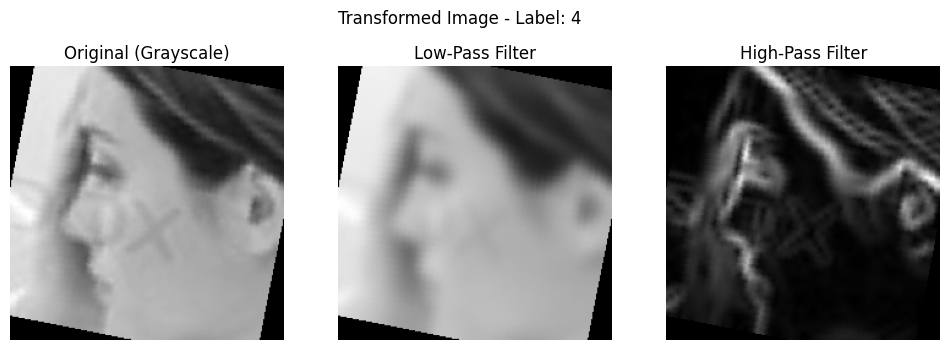

Transformed Image Shape: torch.Size([3, 224, 224])


In [26]:
import matplotlib.pyplot as plt

# Get a sample batch from the DataLoader
data_iter = iter(train_loader)
sample_images, sample_labels = next(data_iter)  # Get the first batch

# First image
image = sample_images[0]  # Shape: (C, H, W)


channel_names = ["Original (Grayscale)", "Low-Pass Filter", "High-Pass Filter"]

#Plotting
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    axes[i].imshow(image[i].numpy(), cmap="gray")  # Use grayscale colormap
    axes[i].set_title(channel_names[i])
    axes[i].axis("off")

plt.suptitle(f"Transformed Image - Label: {sample_labels[0].item()}")
plt.show()


print(f"Transformed Image Shape: {sample_images[0].shape}")  # Expected: (3, H, W)


In [27]:
print(f"Sample image shape before model: {sample_images.shape}")


Sample image shape before model: torch.Size([32, 3, 224, 224])


In [28]:


#from edgevit import edgevit_xxs
sample_images, sample_labels = next(iter(train_loader))
print("Batch Shape:", sample_images.shape)  # Expected: [batch_size, 3, 48, 48]
print("Labels:", sample_labels)



Batch Shape: torch.Size([32, 3, 224, 224])
Labels: tensor([0, 6, 6, 2, 0, 3, 3, 3, 4, 0, 3, 2, 5, 2, 6, 6, 5, 1, 3, 3, 0, 4, 1, 0,
        0, 3, 3, 6, 2, 5, 0, 5])


In [29]:
# Check EdgeViT input compatibility
model = edgevit_xxs(pretrained=False, num_classes=7, in_chans=3)

output = model(sample_images)  # Forward pass
print("Output Shape:", output.shape)  # Expected: [batch_size, 7]

Output Shape: torch.Size([32, 7])


In [ ]:
# from transformers import ViTForImageClassification

# vit_checkpoint_path = "/Users/abhishek/PycharmProjects/pythonProject/facial_emotions_image_detection/checkpoint-2360"  # Replace with your actual path

#
# teacher_model = ViTForImageClassification.from_pretrained(vit_checkpoint_path)

# # Set the model to evaluation mode (for inference & distillation)
# teacher_model.eval()


from transformers import ViTForImageClassification
from huggingface_hub import login

# AuthKey
login(token="")

# Model loading
teacher_model = ViTForImageClassification.from_pretrained("abhishek/betterVitValAcc", use_auth_token=True)

# Evaluate mode
teacher_model.eval()

print("Model loaded successfully!")




/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:3491: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Model loaded successfully!


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from functools import partial



# Constants
TEMPERATURE = 3.0
ALPHA = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
student_model = edgevit_m(num_classes=7)
student_model = student_model.to(device)
teacher_model = teacher_model.to(device)

# Optimizer & Scheduler
optimizer = optim.AdamW(student_model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Distillation Loss Function
def distillation_loss(student_logits, teacher_logits, labels, alpha=ALPHA, temperature=TEMPERATURE):
    hard_loss = F.cross_entropy(student_logits, labels)
    soft_student = F.log_softmax(student_logits / temperature, dim=1)
    soft_teacher = F.softmax(teacher_logits / temperature, dim=1)
    soft_loss = F.kl_div(soft_student, soft_teacher, reduction='batchmean') * (temperature ** 2)
    return alpha * soft_loss + (1 - alpha) * hard_loss


def load_checkpoint(model, optimizer, scheduler, checkpoint):
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler and 'scheduler_state_dict' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    print(f"Loaded model from checkpoint, starting at epoch {checkpoint.get('epoch', 0) + 1}")
    return checkpoint.get('epoch', 0) + 1

# Training script
def train_with_distillation(teacher_model, student_model, train_loader, test_loader, optimizer, scheduler=None,
                            num_epochs=30, device=device, start_epoch=0):
    student_model.train()
    teacher_model.eval()

    for epoch in range(start_epoch, num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)

            gray_channel = images[:, 0:1, :, :]
            rgb_images = gray_channel.repeat(1, 3, 1, 1)

            optimizer.zero_grad()

            student_outputs = student_model(images)
            with torch.no_grad():
                teacher_outputs = teacher_model(rgb_images).logits

            loss = distillation_loss(student_outputs, teacher_outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = student_outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            progress_bar.set_postfix({
                'loss': running_loss / (progress_bar.n + 1),
                'acc': 100. * correct / total
            })

        if scheduler:
            scheduler.step()

        # Print stats for this epoch
        print(f"Epoch {epoch+1}: Loss = {running_loss / len(train_loader):.4f}, "
              f"Training Accuracy = {100. * correct / total:.2f}%")
        
        # Evaluate after every epoch
        test_accuracy = evaluate(student_model, test_loader, device)
        print(f"Test Accuracy after Epoch {epoch+1}: {test_accuracy:.2f}%")

        # Save checkpoint after every epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': student_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None
        }, "checkpoint.pt")


def evaluate(model, test_loader, device=device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


try:
    #checkpoint_url = "https://huggingface.co/abhishek/edgevit-fer/resolve/main/checkpoint.pt"
    checkpoint_url = "https://huggingface.co/abhishek/edgevit-fer/resolve/main/checkpoint-3.pt"
    checkpoint = torch.hub.load_state_dict_from_url(checkpoint_url, map_location=device)
    start_epoch = load_checkpoint(student_model, optimizer, scheduler, checkpoint)
except Exception as e:
    print(f"No checkpoint found or failed to load: {e}")
    start_epoch = 0


student_model = train_with_distillation(
    teacher_model=teacher_model,
    student_model=student_model,
    train_loader=train_loader,
    test_loader=test_loader, 
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=80,
    device=device,
    start_epoch=start_epoch
)


evaluate(student_model, test_loader, device)


Downloading: "https://huggingface.co/<your-username>/edgevit-fer/resolve/main/checkpoint.pt" to /root/.cache/torch/hub/checkpoints/checkpoint.pt


No checkpoint found or failed to load: HTTP Error 401: Unauthorized


Epoch 1/31:  12%|█▏        | 184/1579 [02:59<22:43,  1.02it/s, loss=2.66, acc=22.7]


KeyboardInterrupt: 

In [ ]:
torch.save(student_model.state_dict(), "edgevit_distilled.pth")